# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu

In [4]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [7]:
FONTSIZE = 20

In [8]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [9]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [10]:
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_TRIALS_AND_VIDEO = pd.read_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [11]:
OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3"}

In [12]:
OUTCOME_COMPARISONS = {"win_lose": ("win", "lose"), "lose_omission": ("lose", "omission"), "win_rewarded": ("win", "rewarded")}

In [13]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [14]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [15]:
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5 to 10 cm/s", 3: "10cm/s+"}

In [16]:
MIN_VELOCITY = 0
MAX_VELOCITY = 2.5

In [17]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 6, "high_freq": 11}, "beta": {"low_freq": 20, "high_freq": 31}, "gamma": {"low_freq": 30, "high_freq": 51}}
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}

In [18]:
GROUPINGS = "trial_outcome"

In [19]:
FONTSIZE=20

In [20]:
MERGED_TRIALS_AND_VIDEO.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,baseline_thorax_velocity,trial_thorax_velocity,trial_chunked_thorax_velocity,baseline_chunked_thorax_velocity,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,binned_baseline_thorax_velocity,binned_trial_thorax_velocity
0,30950500,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,27998597,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[1.2476140081638165, 1.1366289071218907, 1.068...","[0.18170472850681613, 0.16961378983662276, 0.2...","[0.49872187702582166, 0.5847505450273386, 1.07...","[1.6838472335457935, 1.7550373254126983, 1.372...","[(27998597, 28018597), (28008597, 28028597), (...","[(27798597, 27818597), (27808597, 27828597), (...","[(1399929, 1400929), (1400429, 1401429), (1400...","[(1389929, 1390929), (1390429, 1391429), (1390...","[0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."
1,32550496,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,29598593,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[2.7236727895073223, 2.628037603947678, 2.5298...","[0.38577700470932025, 0.16352840888997497, 0.0...","[0.3129891797005337, 0.2588847730730972, 0.210...","[1.458421075097482, 0.5407183310858753, 0.2360...","[(29598593, 29618593), (29608593, 29628593), (...","[(29398593, 29418593), (29408593, 29428593), (...","[(1479929, 1480929), (1480429, 1481429), (1480...","[(1469929, 1470929), (1470429, 1471429), (1470...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,34350494,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,31398591,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[5.210405290871598, 5.31421978904958, 5.379251...","[0.16560567036540477, 0.1278165569746918, 0.09...","[0.19868857983610794, 0.508612732615851, 0.481...","[3.439626522203859, 1.5683251160952123, 1.1535...","[(31398591, 31418591), (31408591, 31428591), (...","[(31198591, 31218591), (31208591, 31228591), (...","[(1569929, 1570929), (1570429, 1571429), (1570...","[(1559929, 1560929), (1560429, 1561429), (1560...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,35950496,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,32998593,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,34807,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[1.6555785442563817, 1.6866235492876445, 1.664...","[0.6307901161394641, 0.6655381193431421, 0.701...","[0.4673908122355257, 0.39056964369789443, 0.38...","[0.900289992310536, 0.3533926495729531, 0.2807...","[(32998593, 33018593), (33008593, 33028593), (...","[(32798593, 32818593), (32808593, 32828593), (...","[(1649929, 1650929), (1650429, 1651429), (1650...","[(1639929, 1640929), (1640429, 1641429), (1640...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,37450494,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,34498591,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,36677,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[0.9562352171082348, 0.8615465705681848, 0.756...","[0.15955796441347841, 0.18843088608181321, 0.2...","[0.23449342689004346, 0.17815867178863123, 0.2...","[0.3903027043299651, 0.397100110767035, 0.8705...","[(34498591, 34518591), 

In [21]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,vHPC_baselineandtrial_lfp_trace,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,BLA_baselineandtrial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,LH_baselineandtrial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace,MD_baselineandtrial_lfp_trace
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.07045184, -0.0958607, -0.054282565, 0.1512...","[2.0367692, 2.1165679, 2.162167, 2.2685654, 2....","[0.31159526, 0.35909453, 0.18239723, -0.509192...","[2.0367692, 2.1165679, 2.162167, 2.2685654, 2....","[3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...","[0.78082824, 1.1788379, 0.8415931, -0.40104795...","[3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...","[1.3860394, 1.4873364, 1.7566382, 1.8208753, 1...","[-0.9857927, -0.8746131, -0.7362562, -1.413216...","[1.3860394, 1.4873364, 1.7566382, 1.8208753, 1..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.30606127, 0.22405995, 0.28873706, 0.4100066...","[0.30589536, 0.13679792, -0.064599015, -0.3381...","[0.020899683, -0.05129922, 0.113998264, -0.416...","[0.30589536, 0.13679792, -0.064599015, -0.3381...","[-1.1575702, -1.2699852, -1.3489795, -1.427973...","[0.91754913, 0.4466216, 0.64410734, 0.03342066...","[-1.1575702, -1.2699852, -1.3489795, -1.427973...","[-0.15318082, -0.16800477, 0.019765267, 0.1605...","[1.620752, 1.3415675, 1.4601592, 0.94132084, -...","[-0.15318082, -0.16800477, 0.019765267, 0.1605..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-1.2300198, -1.2323297, -1.3039365, -1.096045...","[-2.0025697, -1.9151709, -1.9436705, -1.552276...","[0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...","[-2.0025697, -1.9151709, -1.9436705, -1.552276...","[-0.20356221, -0.08203254, -0.18837102, -0.142...","[-0.58941895, 0.25521234, 0.66233677, 0.416239...","[-0.20356221, -0.08203254, -0.18837102, -0.142...","[-0.32859758, -0.5361329, -0.97591007, -0.7609...","[0.088943705, 0.8770837, 1.2056813, 0.88696635...","[-0.32859758, -0.5361329, -0.97591007, -0.7609..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[0.1605378, 0.4169363, 0.64561605, 0.6756447, ...","[-1.2729807, -1.0468841, -0.8378873, -0.754288...","[2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...","[-1.2729807, -1.0468841, -0.8378873, -0.754288...","[-2.4792056, -2.1480372, -1.8259835, -1.677109...","[2.7587237, 2.233108, 1.4796239, 0.93274033, 1...","[-2.4792056, -2.1480372, -1.8259835, -1.677109...","[-2.7720788, -2.5620728, -2.3125362, -2.062999...","[2.0802944, 1.7344022, 1.1192082, 0.4521305, 0...","[-2.7720788, -2.5620728, -2.3125362, -2.062999..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.30952612, 0.19056645, 0.4331056, 0.3638087...","[-2.1469674, -2.0690687, -2.0937681, -2.152667...","[-0.18809713, 0.108298354, -0.66878986, -0.944...","[-2.1469674, -2.0690687, -2.0937681, -2.152667...","[-2.1176548, -1.4522797, -1.0360405, -

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [22]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [23]:
def nested_dict():
    return defaultdict(dict)

In [24]:
def mean_of_counter(counter):
    # Extract values from the Counter and calculate the mean
    values = list(counter.values())
    return sum(values) / len(values) if values else 0  # Prevent division by zero

In [25]:
def adjust_lightness(color, amount=0.5):
    """
    Adjusts the lightness of the given color by the provided amount.
    :param color: Input color in some format that matplotlib's `to_rgb` can handle.
    :param amount: Amount to adjust. > 1 for lighter, < 1 for darker.
    :return: Adjusted color.
    """
    import colorsys
    c = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(h, max(0, min(1, amount * l)), s)

In [26]:
def generate_gradient_colors(base_color, num_colors=10):
    """
    Generate gradient colors based on a base color.
    
    :param base_color: The base color to create a gradient from.
    :param num_colors: The number of gradient colors to generate.
    :return: List of colors.
    """
    # Convert base color to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(*mcolors.to_rgb(base_color))

    # Determine the step size for lightness
    middle_index = num_colors // 2
    lightness_step = l / (middle_index if middle_index > 0 else 1)

    colors = []
    for i in range(num_colors):
        if i < middle_index:
            # For the lighter colors (before the middle)
            new_lightness = l + (middle_index - i) * lightness_step
        elif i == middle_index:
            # The middle color remains the base color
            new_lightness = l
        else:
            # For the darker colors (after the middle)
            new_lightness = l - (i - middle_index) * lightness_step

        # Ensure new lightness is within the valid range [0, 1]
        new_lightness = max(0, min(new_lightness, 1))

        new_color = colorsys.hls_to_rgb(h, new_lightness, s)
        colors.append(new_color)

    return colors

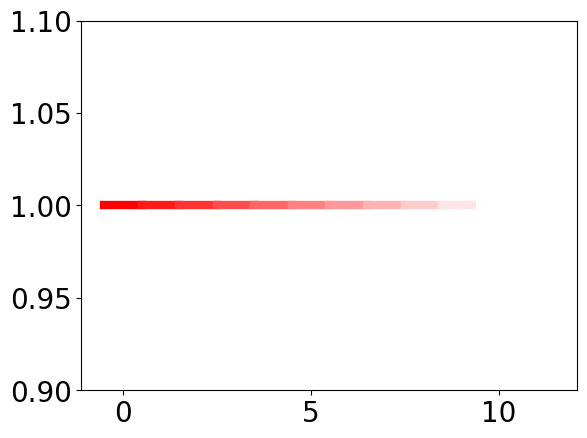

In [27]:
# Original color
original_color = 'red'  # Can be any color matplotlib understands

# Generate lighter versions
lighter_colors = [adjust_lightness(original_color, amount=1+(0.1*i)) for i in range(12)]

# Plotting to demonstrate the colors
for i, color in enumerate(lighter_colors):
    plt.plot([i-0.5, i+0.5], [1, 1], color=color, linewidth=6)  

plt.ylim(0.9, 1.1)
plt.show()

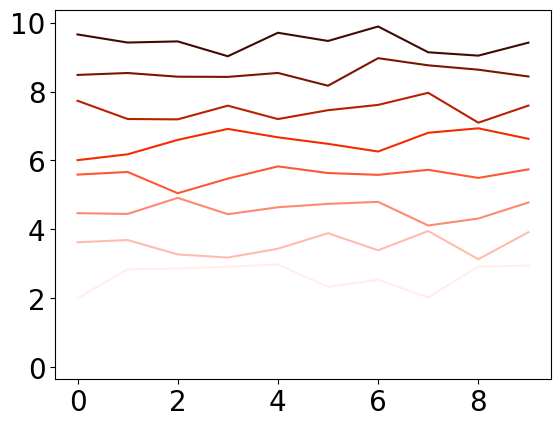

In [28]:
# Base color
base_color = '#ff5733'  # Reddish color

# Number of colors you want in the gradient
num_colors = 10

# Generate gradient colors
gradient_colors = generate_gradient_colors(base_color, num_colors)

# Set the color cycle to use the gradient colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=gradient_colors)

# Test by plotting some data
for i in range(num_colors):
    plt.plot(np.arange(10), np.random.rand(10) + i)

plt.show()

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [29]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [30]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baselineandtrial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baselineandtrial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'BLA_baselineandtrial_lfp_trace', 'LH_baseline_lfp_trace',
       'LH_trial_lfp_trace', 'LH_baselineandtrial_lfp_trace',
       'MD

In [31]:
MERGED_TRIALS_AND_VIDEO.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'track_names', 'subject_id', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_bottom_left', 'reward_port',
       'box_top_lef

### Merging LFP Trace dataframe and SLEAP pose tracking

In [32]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [33]:
MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")

In [34]:
MERGED_LFP_AND_SLEAP.head()

,time,recording_file,video_number,current_subject,mPFC_baseline_lfp_trace,mPFC_trial_lfp_trace,mPFC_baselineandtrial_lfp_trace,vHPC_baseline_lfp_trace,vHPC_trial_lfp_trace,vHPC_baselineandtrial_lfp_trace,...,baseline_thorax_velocity,trial_thorax_velocity,trial_chunked_thorax_velocity,baseline_chunked_thorax_velocity,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,binned_baseline_thorax_velocity,binned_trial_thorax_velocity
0,30950500,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,1.0,6.1,"[-0.3134648, -0.39993784, -0.8777014, -1.44193...","[0.50154364, 0.29617018, 0.22050627, 0.1145767...","[-0.3134648, -0.39993784, -0.8777014, -1.44193...","[0.2583401, -0.26769176, -0.8311303, -1.046219...","[-1.1479185, -1.1806493, -1.1432426, -1.139735...","[0.2583401, -0.26769176, -0.8311303, -1.046219...",...,"[1.2476140081638165, 1.1366289071218907, 1.068...","[0.18170472850681613, 0.16961378983662276, 0.2...","[0.49872187702582166, 0.5847505450273386, 1.07...","[1.6838472335457935, 1.7550373254126983, 1.372...","[(27998597, 28018597), (28008597, 28028597), (...","[(27798597, 27818597), (27808597, 27828597), (...","[(1399929, 1400929), (1400429, 1401429), (1400...","[(1389929, 1390929), (1390429, 1391429), (1390...","[0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."
1,32550496,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,1.0,6.1,"[1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...","[0.31995025, 0.16429879, 0.010809131, 0.067016...","[1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...","[1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...","[-1.0205019, -0.9152954, -0.9947847, -0.976081...","[1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...",...,"[2.7236727895073223, 2.628037603947678, 2.5298...","[0.38577700470932025, 0.16352840888997497, 0.0...","[0.3129891797005337, 0.2588847730730972, 0.210...","[1.458421075097482, 0.5407183310858753, 0.2360...","[(29598593, 29618593), (29608593, 29628593), (...","[(29398593, 29418593), (29408593, 29428593), (...","[(1479929, 1480929), (1480429, 1481429), (1480...","[(1469929, 1470929), (1470429, 1471429), (1470...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,34350494,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,1.0,6.1,"[-0.22482991, 0.3567013, 0.12538591, -0.136195...","[-0.13835686, 0.42804158, 0.5945022, 0.3134648...","[-0.22482991, 0.3567013, 0.12538591, -0.136195...","[-1.0017985, -0.70955855, -0.7002069, -0.68033...","[0.47109076, 0.34016728, 0.18352668, 0.174175,...","[-1.0017985, -0.70955855, -0.7002069, -0.68033...",...,"[5.210405290871598, 5.31421978904958, 5.379251...","[0.16560567036540477, 0.1278165569746918, 0.09...","[0.19868857983610794, 0.508612732615851, 0.481...","[3.439626522203859, 1.5683251160952123, 1.1535...","[(31398591, 31418591), (31408591, 31428591), (...","[(31198591, 31218591), (31208591, 31228591), (...","[(1569929, 1570929), (1570429, 1571429), (1570...","[(1559929, 1560929), (1560429, 1561429), (1560...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,35950496,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,1.0,6.1,"[0.4864109, 0.18591705, 0.397776, 0.24212453, ...","[-0.32211208, 0.023780087, 0.13835686, -0.1102...","[0.4864109, 0.18591705, 0.397776, 0.24212453, ...","[0.58447987, 0.4675839, 0.21275067, 0.03389983...","[0.15780956, 0.047927346, -0.14728892, -0.3565...","[0.58447987, 0.4675839, 0.21275067, 0.03389983...",...,"[1.6555785442563817, 1.6866235492876445, 1.664...","[0.6307901161394641, 0.6655381193431421, 0.701...","[0.4673908122355257, 0.39056964369789443, 0.38...","[0.900289992310536, 0.3533926495729531, 0.2807...","[(32998593, 33018593), (33008593, 33028593), (...","[(32798593, 32818593), (32808593, 32828593), (...","[(1649929, 1650929), (1650429, 1651429), (1650...","[(1639929, 1640929), (1640429, 1641429), (

In [35]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col]

In [36]:
trial_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col and "baselineandtrial" not in col])
baseline_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_lfp_trace" in col and "baselineandtrial" not in col])

In [37]:
trial_trace_columns

['BLA_trial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_trial_lfp_trace',
 'mPFC_trial_lfp_trace',
 'vHPC_trial_lfp_trace']

- Getting the trace column pairs

In [38]:
trial_brain_region_pairs = generate_pairs(trial_trace_columns)
trial_brain_region_pairs = sorted(trial_brain_region_pairs)
baseline_brain_region_pairs = generate_pairs(baseline_trace_columns)
baseline_brain_region_pairs = sorted(baseline_brain_region_pairs)

In [39]:
trial_brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

In [40]:
baseline_brain_region_pairs

[('BLA_baseline_lfp_trace', 'LH_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('mPFC_baseline_lfp_trace', 'vHPC_baseline_lfp_trace')]

- Getting just the region names

In [41]:
all_pair_base_name = []
for region_1, region_2 in trial_brain_region_pairs:
    all_pair_base_name.append("{}_{}".format(region_1.split("_")[0], region_2.split("_")[0]))
all_pair_base_name = sorted(all_pair_base_name)

In [42]:
all_pair_base_name

['BLA_LH',
 'BLA_MD',
 'BLA_mPFC',
 'BLA_vHPC',
 'LH_MD',
 'LH_mPFC',
 'LH_vHPC',
 'MD_mPFC',
 'MD_vHPC',
 'mPFC_vHPC']

# Granger's Causality

In [43]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

- Calculating the granger

In [44]:
trial_brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

In [45]:
for region_1, region_2 in trial_brain_region_pairs:
    region_1_trimmed = region_1.split("_")[0]
    region_2_trimmed = region_2.split("_")[0]
    pair_base_name = "{}_{}".format(region_1_trimmed, region_2_trimmed)
    print(pair_base_name)
    try:
        multitaper_col = "{}_trial_multitaper".format(pair_base_name)
        # MERGED_LFP_AND_SLEAP[multitaper_col] = MERGED_LFP_AND_SLEAP.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT), axis=1)
        MERGED_LFP_AND_SLEAP[multitaper_col] = MERGED_LFP_AND_SLEAP.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, time_window_duration=TIME_WINDOW_DURATION, time_window_step=TIME_WINDOW_STEP), axis=1)
        print("\tcalculating connectivity")
        connectivity_col = "{}_trial_connectivity".format(pair_base_name)
        MERGED_LFP_AND_SLEAP[connectivity_col] = MERGED_LFP_AND_SLEAP[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        MERGED_LFP_AND_SLEAP["{}_trial_frequencies".format(pair_base_name)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: x.frequencies)
        
        print("\t{}_{}_granger".format(region_1_trimmed, region_2_trimmed))
        MERGED_LFP_AND_SLEAP["{}_{}_split_windows_granger".format(region_1_trimmed, region_2_trimmed)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: x.pairwise_spectral_granger_prediction()[:,:,0,1])

        MERGED_LFP_AND_SLEAP["{}_{}_window_mean_granger".format(region_1_trimmed, region_2_trimmed)] = MERGED_LFP_AND_SLEAP["{}_{}_split_windows_granger".format(region_1_trimmed, region_2_trimmed)].apply(lambda x: np.nanmean(x, axis=0))

        print("\t{}_{}_granger".format(region_2_trimmed, region_1_trimmed))
        MERGED_LFP_AND_SLEAP["{}_{}_split_windows_granger".format(region_2_trimmed, region_1_trimmed)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: x.pairwise_spectral_granger_prediction()[:,:,1,0])

        MERGED_LFP_AND_SLEAP["{}_{}_window_mean_granger".format(region_2_trimmed, region_1_trimmed)] = MERGED_LFP_AND_SLEAP["{}_{}_split_windows_granger".format(region_2_trimmed, region_1_trimmed)].apply(lambda x: np.nanmean(x, axis=0))
        
        MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[multitaper_col, connectivity_col], errors="ignore")
        # MERGED_LFP_AND_SLEAP.to_pickle("./proc/per_trial_granger.pkl")
    except Exception as e: 
        print(e)

BLA_LH
	calculating connectivity
	BLA_LH_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


	LH_BLA_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


BLA_MD
	calculating connectivity
	BLA_MD_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


	MD_BLA_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


BLA_mPFC
	calculating connectivity
	BLA_mPFC_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


	mPFC_BLA_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


BLA_vHPC
	calculating connectivity
	BLA_vHPC_granger


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.


	vHPC_BLA_granger


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.


LH_MD
	calculating connectivity
	LH_MD_granger


Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum itera

	MD_LH_granger


Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum itera

LH_mPFC
	calculating connectivity
	LH_mPFC_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


	mPFC_LH_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


LH_vHPC
	calculating connectivity
	LH_vHPC_granger


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.


	vHPC_LH_granger


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 17 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.


MD_mPFC
	calculating connectivity
	MD_mPFC_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged


	mPFC_MD_granger


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged


MD_vHPC
	calculating connectivity
	MD_vHPC_granger


Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.


	vHPC_MD_granger


Maximum iterations reached. 18 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.


mPFC_vHPC
	calculating connectivity
	mPFC_vHPC_granger


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged


	vHPC_mPFC_granger


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 17 of 19 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 18 of 19 converged


In [46]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/per_trial_granger.pkl")


In [47]:
raise ValueError()

ValueError: 

In [ ]:
MERGED_LFP_AND_SLEAP["BLA_LH_trial_frequencies"].iloc[0]

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
GROUPINGS = "trial_outcome"

In [ ]:
all_frequencies = MERGED_LFP_AND_SLEAP["BLA_LH_trial_frequencies"].iloc[0]

In [ ]:
low_freq = 0
high_freq = 100

for region_1, region_2 in trial_brain_region_pairs:
    region_1_trimmed = region_1.split("_")[0]
    region_2_trimmed = region_2.split("_")[0]
    
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_1_trimmed, region_2_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    ax.axvspan(12, 30, alpha=0.1, color='cyan', label="beta")
    ax.axvspan(30, 90, alpha=0.1, color='magenta', label="gamma")
    
    granger_col = "{}_{}_window_mean_granger".format(region_1_trimmed, region_2_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)

    plt.legend(ncol=3, loc="lower center")

    plt.savefig("./proc/{}_{}_granger_{}_{}hz.png".format(region_1_trimmed, region_2_trimmed, low_freq, high_freq))
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_2_trimmed, region_1_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    ax.axvspan(12, 30, alpha=0.1, color='cyan', label="beta")
    ax.axvspan(30, 90, alpha=0.1, color='magenta', label="gamma")
    
    granger_col = "{}_{}_window_mean_granger".format(region_2_trimmed, region_1_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)
    
    plt.legend(ncol=3, loc="lower center")

    plt.savefig("./proc/{}_{}_granger_{}_{}hz.png".format(region_2_trimmed, region_1_trimmed, low_freq, high_freq))

    plt.show()
    
    


In [ ]:
low_freq = 0
high_freq = 12

for region_1, region_2 in trial_brain_region_pairs:
    region_1_trimmed = region_1.split("_")[0]
    region_2_trimmed = region_2.split("_")[0]
    
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_1_trimmed, region_2_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    # ax.axvspan(12, 30, alpha=0.1, color='cyan', label="beta")
    # ax.axvspan(30, 90, alpha=0.1, color='magenta', label="gamma")
    
    granger_col = "{}_{}_window_mean_granger".format(region_1_trimmed, region_2_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)

    # plt.legend(ncol=3, loc="lower center")

    plt.savefig("./proc/{}_{}_granger_{}_{}hz.png".format(region_1_trimmed, region_2_trimmed, low_freq, high_freq))
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_2_trimmed, region_1_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    
    granger_col = "{}_{}_window_mean_granger".format(region_2_trimmed, region_1_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)
    
    # plt.legend(ncol=3, loc="lower center")

    plt.savefig("./proc/{}_{}_granger_{}_{}hz.png".format(region_2_trimmed, region_1_trimmed, low_freq, high_freq))

    plt.show()
    
    


# Network Predictivity

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged" in col and ("granger" in col or "coherence" in col)]
feature_columns = [col for col in feature_columns if "beta" not in col]

In [ ]:
feature_columns

- Filtering out for trials that are win vs loss

In [ ]:
network_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"].isin(["win", "lose", "rewarded"])]
network_df = network_df.dropna(subset="mPFC_MD_averaged_gamma_granger")

In [ ]:
network_df.groupby("trial_outcome").count()

In [ ]:
network_array = network_df[feature_columns].values

In [ ]:
network_df.head()

In [ ]:
original_scores=[]
kFold=KFold(n_splits=5,shuffle=True)


all_predictions = []
all_labels = []

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)

for train_index, test_index in kFold.split(network_array):
    
    X_train = network_array[train_index]  
    X_test = network_array[test_index]
    y_train = network_df["trial_outcome"].values[train_index]
    y_test = network_df["trial_outcome"].values[test_index]

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 
    all_predictions += clf.predict(X_test).tolist()
    all_labels += y_test.tolist()
    
    original_scores.append(clf.score(X_test,y_test))
mean_original_scores = np.mean(original_scores)
# 0.9393939393939394


In [ ]:
len(train_index)

In [ ]:
len(network_df)

In [ ]:
original_scores

In [ ]:
y_test

In [ ]:
clf.predict(X_test)

In [ ]:
OUTCOME_LABELS=["win", "lose", "rewarded"]

In [ ]:
#compute the confusion matrix.
# cm = confusion_matrix(clf.predict(X_test),y_test, labels=OUTCOME_LABELS)
cm = confusion_matrix(all_predictions,all_labels, labels=OUTCOME_LABELS)


#Plot the confusion matrix.
sns.heatmap(cm/sum(cm), 
            annot=True,
            # fmt='g', 
            fmt='.2%',
           cmap="Blues", xticklabels=OUTCOME_LABELS, yticklabels=OUTCOME_LABELS)
# sns.light_palette("seagreen", as_cmap=True)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Random Forest of\nCoherence and Granger's Causality",fontsize=17)
plt.savefig("./proc/rf_original_connectivity_confusion_matrix.png")

plt.show()

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [ ]:
std

In [ ]:
forest_importances = pd.DataFrame(importances, index=feature_columns).sort_values(0, ascending=False).reset_index()
forest_importances = forest_importances.rename(columns={0: "mdi"})

In [ ]:
forest_importances["index"]

In [ ]:
forest_importances["brain_regions"] = forest_importances["index"].apply(lambda x: x.split("_")[:2])
forest_importances["measure"] = forest_importances["index"].apply(lambda x: x.split("_")[-1])
forest_importances["band"] = forest_importances["index"].apply(lambda x: x.split("_")[-2])

In [ ]:
forest_importances = forest_importances.iloc[:10]

In [ ]:
forest_importances["color"] = forest_importances["band"].map(BAND_TO_COLOR)
forest_importances["pattern"] = forest_importances["measure"].map(MEASURE_TO_PATTERN)

In [ ]:
forest_importances["index"] = forest_importances["index"].apply(lambda x: " ".join([_.strip("_") for _ in x.split("averaged")]))

In [ ]:
forest_importances

In [ ]:
for index, row in forest_importances.iterrows():
    plt.bar(row["index"], row["mdi"], color=row["color"], label="{} {}".format(row["band"], row["measure"]), hatch=row["pattern"])

plt.xticks(fontsize=10, rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Feature importances for winning/losing", fontsize=20)
plt.ylabel("Mean decrease in impurity", fontsize=20)
# plt.tight_layout()
plt.savefig("./proc/network/rf_connectivity_feature_importance.png")
plt.show()

- Shuffling the labels

In [ ]:
shuffled_scores=[]
kFold=KFold(n_splits=5,shuffle=True)


all_predictions = []
all_labels = []

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)

for train_index, test_index in kFold.split(network_array):
    
    X_train = network_array[train_index]  
    X_test = network_array[test_index]
    y_train = shuffle(network_df["trial_outcome"].values[train_index])
    y_test = network_df["trial_outcome"].values[test_index]

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 
    all_predictions += clf.predict(X_test).tolist()
    all_labels += y_test.tolist()
    
    shuffled_scores.append(clf.score(X_test,y_test))
mean_shuffled_scores = np.mean(shuffled_scores)
# 0.9393939393939394


In [ ]:
shuffled_scores

In [ ]:
y_test

In [ ]:
clf.predict(X_test)

In [ ]:
clf.predict(X_test),y_test

In [ ]:
#compute the confusion matrix.
# cm = confusion_matrix(clf.predict(X_test),y_test, labels=OUTCOME_LABELS)
cm = confusion_matrix(all_predictions,all_labels, labels=OUTCOME_LABELS)


#Plot the confusion matrix.
sns.heatmap(cm/sum(cm), 
            annot=True,
            # fmt='g', 
            fmt='.2%',
           cmap="Blues", xticklabels=OUTCOME_LABELS, yticklabels=OUTCOME_LABELS)
# sns.light_palette("seagreen", as_cmap=True)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Random forest of shuffled connectivity',fontsize=17)
plt.savefig("./proc/rf_shuffled_connectivity_confusion_matrix.png")

plt.show()

In [ ]:
shuffled_scores

In [ ]:
original_scores

In [ ]:
plt.bar(x=["Granger and Coherence", "Shuffled"], height=[np.mean(original_scores), np.mean(shuffled_scores)], color= ["#FFAF00", "#15616F"])
plt.ylabel("Accuracy", fontsize=20)
plt.title("Random Forest Connectivity Accuracy", fontsize=20)
plt.errorbar(["Granger and Coherence", "Shuffled"], [np.mean(original_scores), np.mean(shuffled_scores)], yerr=[stats.sem(original_scores), stats.sem(shuffled_scores)], fmt="o", color="black", capsize=10)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("./proc/rf_connectivity_predictions_score.png")

In [ ]:
raise ValueError()

In [ ]:
# Simulate signal
frequency_of_interest = [200, 50]
sampling_frequency = 1500
time_extent = (0, 50)
n_time_samples = ((time_extent[1] - time_extent[0]) * sampling_frequency) + 1
time = np.linspace(time_extent[0], time_extent[1], num=n_time_samples, endpoint=True)
signal = np.sin(2 * np.pi * time[:, np.newaxis] * frequency_of_interest)
signal[: n_time_samples // 2, 1] = 0
signal = signal.sum(axis=1)
noise = np.random.normal(0, 4, signal.shape)

# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
axes[0, 0].plot(time, signal)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].set_title("Signal", fontweight="bold")
axes[0, 0].set_xlim((24.90, 25.10))
axes[0, 0].set_ylim((-10, 10))

axes[0, 1].plot(time, signal + noise)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Amplitude")
axes[0, 1].set_title("Signal + Noise", fontweight="bold")
axes[0, 1].set_xlim((24.90, 25.10))
axes[0, 1].set_ylim((-10, 10))

multitaper = Multitaper(
    signal,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
axes[1, 0].plot(connectivity.frequencies, connectivity.power().squeeze())
axes[1, 0].set_xlabel("Frequency")
axes[1, 0].set_ylabel("Power")

multitaper = Multitaper(
    signal + noise,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
axes[1, 1].plot(connectivity.frequencies, connectivity.power().squeeze())
axes[1, 1].set_xlabel("Frequency")
axes[1, 1].set_ylabel("Power")


multitaper = Multitaper(
    signal,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=0.600,
    time_window_step=0.300,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
mesh = axes[2, 0].pcolormesh(
    connectivity.time,
    connectivity.frequencies,
    connectivity.power().squeeze().T,
    vmin=0.0,
    vmax=0.03,
    cmap="viridis",
    shading="auto",
)
axes[2, 0].set_ylim((0, 300))
axes[2, 0].axvline(time[int(np.fix(n_time_samples / 2))], color="black")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].set_xlabel("Time")

multitaper = Multitaper(
    signal + noise,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=0.600,
    time_window_step=0.300,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
mesh = axes[2, 1].pcolormesh(
    connectivity.time,
    connectivity.frequencies,
    connectivity.power().squeeze().T,
    vmin=0.0,
    vmax=0.03,
    cmap="viridis",
    shading="auto",
)
axes[2, 1].set_ylim((0, 300))
axes[2, 1].axvline(time[int(np.fix(n_time_samples / 2))], color="black")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].set_xlabel("Time")

plt.tight_layout()
cb = fig.colorbar(
    mesh,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    shrink=0.5,
    aspect=15,
    pad=0.1,
    label="Power",
)
cb.outline.set_linewidth(0)


In [ ]:
BAND_TO_ALL_COL = {"theta": [], "beta": [], "gamma": []}

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
all_granger_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "window_mean_granger" in col]


In [ ]:
all_granger_col

In [ ]:
for band, frequency in BAND_TO_FREQ.items():
    for col in all_granger_col:
        BAND_COL = "{}_averaged_{}_granger".format("_".join(col.split("_")[:2]), band)
        BAND_TO_ALL_COL[band].append(BAND_COL)
        print(BAND_COL)
        print(frequency[0], frequency[1])
        MERGED_LFP_AND_SLEAP[BAND_COL] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: np.nanmean(x[frequency[0]:frequency[1]]))    
        # MERGED_LFP_AND_SLEAP[BAND_COL] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: x[frequency[0]:frequency[1]])    


In [ ]:
MERGED_LFP_AND_SLEAP["BLA_LH_averaged_theta_granger"].iloc[0]

In [ ]:
MERGED_LFP_AND_SLEAP[col].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP[GROUPINGS].unique()

In [ ]:
region_pair_to_outcome_to_granger = {k: defaultdict(nested_dict) for k,v in BAND_TO_FREQ.items()}

for band, frequency in BAND_TO_FREQ.items():
    for outcome in MERGED_LFP_AND_SLEAP[GROUPINGS].unique():
        outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == outcome].copy()
        for band_col in set(BAND_TO_ALL_COL[band]):
            region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["mean"] = outcome_df[band_col].mean() 
            region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["sem"] = outcome_df[band_col].sem() 




In [ ]:
BAND_TO_ALL_COL[band]

In [ ]:
import matplotlib

In [ ]:
font = {'weight' : 'bold',
        'size'   : 36}

matplotlib.rc('font', **font)

In [ ]:
for band, frequency in BAND_TO_FREQ.items(): 
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in region_pair_to_outcome_to_granger[band].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "granger": bar_dict["mean"], "sem": bar_dict["sem"]})
    df = pd.DataFrame(data).sort_values(by=["Group", "Bar"])
    df["color"] = df["Bar"].map(OUTCOME_TO_COLOR)    
    fig, ax = plt.subplots(figsize=(24,12))
    
    
    # Create barplot
    ax = sns.barplot(x='Group', y='granger', hue='Bar', data=df, palette=df["color"], ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group  # the width of the bars
    x_positions = []  # this will store the x positions for the error bars

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]  # filter the dataframe for the specific group
        num_bars = group_data.shape[0]  # get the number of bars for this group
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)  # add these positions to the list

        for pos, (idx, row) in zip(group_positions, group_data.iterrows()):
            height = row['granger']
            error = row['sem']
            plt.errorbar(pos, height, yerr=error, color='black', capsize=2, fmt='none', zorder=10)
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs", fontsize=40)
    plt.ylabel("{} granger".format(band.title()), fontsize=40)
    plt.legend(title="Trial Conditions", loc="lower left", ncol=4)
    plt.title("{} granger".format(band.title()), fontsize=40)
    plt.tight_layout()
    plt.grid()
    plt.ylim(0,0.5)
    # ax.get_legend().remove()

    plt.savefig("./proc/granger/all_zscored_{}_lfp_power_granger.png".format(band))
    # Show the plot
    plt.show()

In [ ]:
trial_outcome_pairs = ("win", "lose"), ("win", "rewarded"), ("lose", "omission")

In [ ]:
for band, frequency in BAND_TO_FREQ.items():
    print(band)

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
MERGED_LFP_AND_SLEAP["trial_outcome"].unique()

In [ ]:
region_to_mannwhitneyu = defaultdict(dict)
region_to_mannwhitneyu = []

for band, frequency in BAND_TO_FREQ.items():
    print(band)
    for region_col in [col for col in MERGED_LFP_AND_SLEAP.columns if band in col]:
        print(region_col)  
        for outcome_pair in trial_outcome_pairs:
            outcome_1_granger = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == outcome_pair[0]][region_col].dropna()
            outcome_2_granger = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == outcome_pair[1]][region_col].dropna()
            statistic, p_value = mannwhitneyu(outcome_1_granger, outcome_2_granger, alternative='two-sided')
            region_to_mannwhitneyu.append({"band": band, "region": region_col, "p_value": p_value, "statistic": statistic, "outcome": outcome_pair})
            
            # region_to_mannwhitneyu[region_col][outcome_pair] = p_value
            # print(region_col)
    
    
    # for outcome in MERGED_LFP_AND_SLEAP[GROUPINGS].unique():
    #     outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == outcome].copy()
    #     for band_col in BAND_TO_ALL_COL[band]:
    #         region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["mean"] = outcome_df[band_col].mean() 
    #         region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["sem"] = outcome_df[band_col].sem() 




In [ ]:
granger_mannwhitneyu = pd.DataFrame(region_to_mannwhitneyu)

In [ ]:
granger_mannwhitneyu[granger_mannwhitneyu["p_value"] <= 0.001/3].sort_values(["p_value", "region"], ascending=True)

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns="functional_graph", errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/MERGED_LFP_AND_SLEAP.pkl")

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
for col in MERGED_LFP_AND_SLEAP:
    print(col)

# Network Analysis

In [ ]:
raise ValueError()

In [ ]:
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged" in col and "coherence" in col or "averaged" in col and "granger" in col]

In [ ]:
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "gamma" in col]
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged" in col]

In [ ]:
feature_columns

In [ ]:
import networkx as nx


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import numpy as np

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

# importing random forest classifier from assemble module 
from sklearn.ensemble import RandomForestClassifier 


In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def get_region_network(row, columns, low_index=0, high_index=1):
    directed_graph = nx.DiGraph()
    for col in columns:
        region_1 = col.split("_")[0]
        region_2 = col.split("_")[1]
        directed_graph.add_edge(region_1, region_2, weight=np.mean(row[col][low_index:high_index]))
    return directed_graph

In [ ]:
network_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"].isin(["win", "lose"])]


In [ ]:
network_array = network_df[feature_columns]

In [ ]:
scaler = StandardScaler()
scaler.fit(network_array)

In [ ]:
network_array = scaler.transform(network_array)

In [ ]:
non_nan_mask = ~np.isnan(network_array).any(axis=1)

In [ ]:
from sklearn.model_selection import KFold


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(network_array[non_nan_mask], network_df["trial_outcome"][non_nan_mask], test_size = 0.20) 

In [ ]:
scores=[]
kFold=KFold(n_splits=5,shuffle=False)

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)   
for train_index,test_index in kFold.split(network_array[non_nan_mask]):
    # print("Train Index: ", train_index, "\n")
    # print("Test Index: ", test_index)
    
    X_train, X_test, y_train, y_test = network_array[non_nan_mask][train_index], network_array[non_nan_mask][test_index], network_df["trial_outcome"][non_nan_mask].values[train_index], network_df["trial_outcome"][non_nan_mask].values[test_index]

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 
    scores.append(clf.score(X_test,y_test))
print(np.mean(scores))
# 0.9393939393939394


In [ ]:
scores

In [ ]:

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [ ]:
std

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
forest_importances = pd.DataFrame(importances, index=feature_columns).sort_values(0, ascending=False).reset_index()
forest_importances = forest_importances.rename(columns={0: "mdi"})

In [ ]:
forest_importances["brain_regions"] = forest_importances["index"].apply(lambda x: x.split("_")[:2])
forest_importances["measure"] = forest_importances["index"].apply(lambda x: x.split("_")[-1])
forest_importances["band"] = forest_importances["index"].apply(lambda x: x.split("_")[-2])

In [ ]:
forest_importances = forest_importances.iloc[:20]

In [ ]:
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [ ]:
BAND_TO_COLOR = {"theta": "green", "beta": "blue", "gamma": "red"}

In [ ]:
MEASURE_TO_PATTERN = {"granger": "o", "coherence": ""}

In [ ]:
forest_importances["color"] = forest_importances["band"].map(BAND_TO_COLOR)
forest_importances["pattern"] = forest_importances["measure"].map(MEASURE_TO_PATTERN)

In [ ]:
forest_importances

In [ ]:
from collections import OrderedDict

In [ ]:
for index, row in forest_importances.iterrows():
    plt.bar(row["index"], row["mdi"], color=row["color"], label="{} {}".format(row["band"], row["measure"]), hatch=row["pattern"])

plt.xticks(fontsize=10, rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Feature importances for winning/losing", fontsize=20)
plt.ylabel("Mean decrease in impurity", fontsize=20)
# plt.tight_layout()
plt.savefig("./proc/network/rf_feature_importance.png")
plt.show()

In [ ]:
forest_importances.groupby(["measure", "band"])["mdi"].mean()

In [ ]:
from grakel import GraphKernel

In [ ]:
from grakel import Graph

In [ ]:
edges = {(1, 2): 1, (1, 3): 1, (2, 1): 1, (3, 1): 1}
edge_attributes = {(1, 2): [0.2, 0.8, 1.3], (1, 3): [1.1, 0.1, 0.7], (2, 1): [0.2, 0.8, 1.3], (3, 1): [1.1, 0.1, 0.7]}
G = Graph(edges, edge_labels=edge_attributes)

In [ ]:
trial_trace_columns = sorted([col.split("_")[0] for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col])


In [ ]:
trial_brain_region_pairs = generate_pairs(trial_trace_columns)


In [ ]:
trial_brain_region_pairs

In [ ]:


from itertools import product

In [ ]:
feature_df = pd.DataFrame(feature_columns, columns=["index"])

In [ ]:
feature_df = pd.DataFrame(feature_columns, columns=["index"])
feature_df["brain_regions"] = feature_df["index"].apply(lambda x: x.split("_")[:2])
feature_df["measure"] = feature_df["index"].apply(lambda x: x.split("_")[-1])
feature_df["band"] = feature_df["index"].apply(lambda x: x.split("_")[-2])

In [ ]:
feature_df

In [ ]:
feature_df["brain_regions"].str.contains(region_1)

In [ ]:
edge_attributes

In [ ]:
MERGED_LFP_AND_SLEAP["LH_BLA_averaged_theta_granger"]

In [ ]:
def create_functional_graph(row, columns, brain_region_pairs=None, measures=None, bands=None):
    """
    """
    if brain_region_pairs is None:
        brain_region_pairs = [('BLA', 'LH'),
         ('BLA', 'MD'),
         ('BLA', 'mPFC'),
         ('BLA', 'vHPC'),
         ('LH', 'MD'),
         ('LH', 'mPFC'),
         ('LH', 'vHPC'),
         ('MD', 'mPFC'),
         ('MD', 'vHPC'),
         ('mPFC', 'vHPC')]

    if measures is None:
        measures = ["coherence", "granger"]

    if bands is None:
        bands = ["theta", "beta", "gamma"]
    try:
        feature_df = pd.DataFrame(columns, columns=["index"])
        feature_df["brain_regions"] = feature_df["index"].apply(lambda x: x.split("_")[:2])
        feature_df["measure"] = feature_df["index"].apply(lambda x: x.split("_")[-1])
        feature_df["band"] = feature_df["index"].apply(lambda x: x.split("_")[-2])
        
        edges = {}
        edge_attributes = {}
        all_columns = []
        for region_1, region_2 in brain_region_pairs:
            # print(region_1)
            # print(region_2)
            edges[(region_1, region_2)] = 1
            edges[(region_2, region_1)] = 1
            edge_attributes[(region_1, region_2)] = []
            edge_attributes[(region_2, region_1)] = []
            for measure in measures:
                for band in bands:
                    for col in feature_df[(feature_df["band"] == band) & (feature_df["measure"] == measure) & (feature_df["brain_regions"].apply(lambda x: region_1 in x)) & ((feature_df["brain_regions"].apply(lambda x: region_2 in x)))]["index"]:
                        # print(col)
                        reg_1 = col.split("_")[0]
                        reg_2 = col.split("_")[1]
                        if "coherence" in col:
                            # print(reg_2, reg_1)
                            edge_attributes[(reg_2, reg_1)].append(row[col])      
                        # print(reg_1, reg_2)
                        edge_attributes[(reg_1, reg_2)].append(row[col])
                        all_columns.append(col)
        return all_columns, Graph(edges, edge_labels=edge_attributes)
    except Exception as e: 
        print(e)   
        return np.nan

In [ ]:
edges = {(1, 2): 1, (1, 3): 1, (2, 1): 1, (3, 1): 1}
edge_attributes = {(1, 2): [0.2, 0.8, 1.3], (1, 3): [1.1, 0.1, 0.7], (2, 1): [0.2, 0.8, 1.3], (3, 1): [1.1, 0.1, 0.7]}
G = Graph(edges, edge_labels=edge_attributes)

In [ ]:
G.edge_dictionary

In [ ]:
MERGED_LFP_AND_SLEAP["BLA_LH_averaged_theta_coherence"]

In [ ]:
MERGED_LFP_AND_SLEAP["functional_graph"] = MERGED_LFP_AND_SLEAP.apply(lambda x: create_functional_graph(x, feature_columns), axis=1)

In [ ]:
MERGED_LFP_AND_SLEAP["all_columns"] = MERGED_LFP_AND_SLEAP["functional_graph"].apply(lambda x: x[0])
MERGED_LFP_AND_SLEAP["functional_graph"] = MERGED_LFP_AND_SLEAP["functional_graph"].apply(lambda x: x[1])

In [ ]:
MERGED_LFP_AND_SLEAP["functional_graph"].iloc[0].edge_dictionary

In [ ]:
from grakel.kernels import WeisfeilerLehman, VertexHistogram
wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)

In [ ]:
from grakel.kernels import neighborhood_subgraph_pairwise_distance

In [ ]:
kernel = neighborhood_subgraph_pairwise_distance

In [ ]:
kernel = kernel.NeighborhoodSubgraphPairwiseDistance(n_jobs=5, normalize=True)

In [ ]:
kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)

In [ ]:
from grakel.datasets import fetch_dataset
MUTAG = fetch_dataset("MUTAG", verbose=False)
G = MUTAG.data
y = MUTAG.target

In [ ]:
from sklearn.model_selection import train_test_split
G_train, G_test, y_train, y_test = train_test_split(MERGED_LFP_AND_SLEAP["functional_graph"], MERGED_LFP_AND_SLEAP["trial_outcome"], test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)

In [ ]:
example = G_train[0]

In [ ]:
example.node_labels

In [ ]:
import networkx as nx

G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)

# Add weighted edges
G.add_edge(1, 2, weight=0.5)
G.add_edge(1, 2, weight=0.5)
G.add_edge(1, 2, weight=0.5)

G.add_edge(2, 3, weight=1.5)
G.add_edge(1, 3, weight=1.0)

In [ ]:
graph = [(dict(G_train[0].nodes(data=True)), dict(G_train[0].edges(data=True)))]

In [ ]:
K_train = kernel.fit_transform(G_train)

In [ ]:
example.edge_dictionary

In [ ]:
neighborhood_subgraph_pairwise_distance

In [ ]:
example = G_train[0]

In [ ]:
G[0]

In [ ]:
edges = {}
edge_attributes = {}
all_columns = []
for region_1, region_2 in trial_brain_region_pairs:
    print(region_1)
    print(region_2)
    edges[(region_1, region_2)] = 1
    edges[(region_2, region_1)] = 1
    edge_attributes[(region_1, region_2)] = []
    edge_attributes[(region_2, region_1)] = []
    for measure in ["coherence", "granger"]:
        for band in BAND_TO_FREQ:
            for col in feature_df[(feature_df["band"] == band) & (feature_df["measure"] == measure) & (feature_df["brain_regions"].apply(lambda x: region_1 in x)) & ((feature_df["brain_regions"].apply(lambda x: region_2 in x)))]["index"]:
                print(col)
                reg_1 = col.split("_")[0]
                reg_2 = col.split("_")[1]
                if "coherence" in col:
                    print(reg_2, reg_1)
                    edge_attributes[(reg_2, reg_1)].append(MERGED_LFP_AND_SLEAP[col].iloc[0])      
                print(reg_1, reg_2)
                edge_attributes[(reg_1, reg_2)].append(MERGED_LFP_AND_SLEAP[col].iloc[0])
                all_columns.append(col)

In [ ]:
edge_attributes

In [ ]:
BAND_TO_FREQ

In [ ]:
feature_columns

In [ ]:
edges

In [ ]:
feature_columns

In [ ]:
pair_base_name

In [ ]:
edges = {(1, 2): 1, (1, 3): 1, (2, 1): 1, (3, 1): 1}
edge_attributes = {(1, 2): [0.2, 0.8, 1.3], (1, 3): [1.1, 0.1, 0.7], (2, 1): [0.2, 0.8, 1.3], (3, 1): [1.1, 0.1, 0.7]}
G = Graph(edges, edge_labels=edge_attributes)

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
forest_importances.sort_values(0, ascending=False).head(n=25)

In [ ]:
plt.bar(forest_importances.sort_values(0, ascending=False).head(n=25))

In [ ]:
forest_importances = pd.DataFrame(importances, index=feature_columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, fontsize=5)
ax.set_title("Feature importances using MDI\nfor winning/losing with Gamma Granger Causality", fontsize=10)
ax.set_ylabel("Mean decrease in impurity", fontsize=10)
fig.tight_layout()
plt.savefig("./proc/network/rf_feature_importance.png")

# Exporting the power spectra

In [ ]:
raise ValueError()

In [ ]:
trace_columns

In [ ]:
exported_lfp_and_sleap = MERGED_LFP_AND_SLEAP.drop(columns=trace_columns, errors="ignore").copy()
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "multitaper" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "thorax_velocity" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "frequencies" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "windowed_power" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "connectivity" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "spike_interface" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "index" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "stamp" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "box" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "height" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "width" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "ratio" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "width" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=['individual_subj',
 'all_subj',
 'recording_name',
 'track_names',
 'subject_id',
 'corner_path',
 'corner_parts',
 'rescaled_locations',
 'reward_port'], errors="ignore")
# exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "all_window_power" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "window_averaged_power" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "all_power" in col], errors="ignore")





In [ ]:
exported_lfp_and_sleap["frequencies"] = [MERGED_LFP_AND_SLEAP["BLA_baseline_frequencies"].iloc[0] for _ in range(len(exported_lfp_and_sleap))] 

In [ ]:
for col in exported_lfp_and_sleap.columns:
    print(col)

In [ ]:
exported_lfp_and_sleap.to_pickle("./proc/rce_lfp_power_and_velocity_region_col_baselinetrial_row.pkl")

In [ ]:
raise ValueError()

# Reformatting the data

In [ ]:
exported_lfp_and_sleap

In [ ]:
window_averaged_power_columns

In [ ]:
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "all_window" in col], errors="ignore")


In [ ]:
exported_lfp_and_sleap = pd.melt(exported_lfp_and_sleap, value_vars=window_averaged_power_columns, value_name="power", id_vars=[col for col in exported_lfp_and_sleap.columns if col not in window_averaged_power_columns], var_name="region_and_baseline_or_trial")



In [ ]:
exported_lfp_and_sleap

In [ ]:
exported_lfp_and_sleap["brain_region"] = exported_lfp_and_sleap["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
exported_lfp_and_sleap["trial_or_baseline"] = exported_lfp_and_sleap["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
exported_lfp_and_sleap.head()

In [ ]:
exported_lfp_and_sleap = exported_lfp_and_sleap.dropna(subset="power")
exported_lfp_and_sleap = exported_lfp_and_sleap[exported_lfp_and_sleap["trial_or_baseline"] == "trial"]
exported_lfp_and_sleap["all_theta_power"] = exported_lfp_and_sleap["power"].apply(lambda x: x[4:13])
exported_lfp_and_sleap["all_beta_power"] = exported_lfp_and_sleap["power"].apply(lambda x: x[13:31])
exported_lfp_and_sleap["all_gamma_power"] = exported_lfp_and_sleap["power"].apply(lambda x: x[30:91])
exported_lfp_and_sleap["mean_theta_power"] = exported_lfp_and_sleap["all_theta_power"].apply(lambda x: x.mean())
exported_lfp_and_sleap["mean_beta_power"] = exported_lfp_and_sleap["all_beta_power"].apply(lambda x: x.mean())
exported_lfp_and_sleap["mean_gamma_power"] = exported_lfp_and_sleap["all_gamma_power"].apply(lambda x: x.mean())

In [ ]:
exported_lfp_and_sleap.head()

In [ ]:
exported_lfp_and_sleap

In [ ]:
exported_lfp_and_sleap.to_pickle("./proc/rce_velocity_parsed_power_spectra_region_and_baselinetrial_rows.pkl")